In [58]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v2") # подгружаем среду
state_size = env.observation_space.shape[0] # все, что агент получает от среды
action_size = env.action_space.n # все возможные действия агента

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # все вычисления переносим на процессор

learning_rate = 1e-3
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
memory_size = 100_000
target_update_freq = 10
num_episodes = 500
max_steps = 1000 # гиперпараметры

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size): # пилим нейронку
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q = value + (advantage - advantage.mean(dim=1, keepdim=True))# выход нейросети
        return q

class DQNAgent:
    def __init__(self):
        self.policy_net = DuelingDQN(state_size, action_size).to(device)
        self.target_net = DuelingDQN(state_size, action_size).to(device) # делаем две нейронки агента
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate) # оптимайзер обычный адам
        self.memory = deque(maxlen=memory_size)
        self.epsilon = epsilon

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values).item()

    def replay(self): # в целом, тут все как в семинаре 7 (там было рассказано про DQN)
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        current_q = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + gamma * next_q * (1 - dones)

        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > epsilon_min:
            self.epsilon *= epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict()) # копируем архитектуру сети

agent = DQNAgent() # инициализируем агента
all_rewards = []

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0

    for step in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
        if done:
            break

    agent.update_target()
    all_rewards.append(total_reward)
env.close()



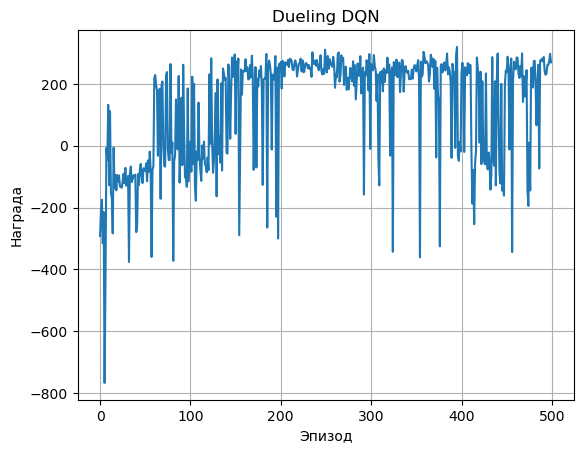

In [62]:
plt.plot(all_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.title("Dueling DQN")
plt.grid()
plt.show()
